In [1]:
# import os
# os.getcwd()
# os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
from scipy.special import spherical_jn, lpmv, sph_harm
from math import factorial, sqrt, pi
import matplotlib.pyplot as plt
from tabulate import tabulate
from termcolor import colored


<Figure size 1152x1152 with 0 Axes>

In [2]:
def grid_coords(grid):
    if grid=='SC':
        # 6 orientations following the arrangement of standard dice
        # 1/6 for +x/-x; 2/5 for +y/-y; 3/4 for +z/-z
        r_n = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,-1],[0,-1,0],[-1,0,0]])
        r_opp = np.array([5,4,3,2,1,0])
    
    if grid=='RB':
        # rhombic dodecahedron
        r_n = np.array([[0,1,1],[0,-1,-1],[0,1,-1],[0,-1,1],
                        [1,0,1],[-1,0,-1],[1,0,-1],[-1,0,1],
                        [1,1,0],[-1,-1,0],[1,-1,0],[-1,1,0]])/np.sqrt(2)
        r_opp = np.array([1,0,3,2,
                          5,4,7,6,
                          9,8,11,10])
        
    if grid=='RT':
        phi = (1+np.sqrt(5))/2
        # rhombic triacontahedron
        r_n = np.array([
                       [phi,0,0],[0,phi,0],[0,0,phi],
                       [-phi,0,0],[0,-phi,0],[0,0,-phi],
                       [1/2,phi/2,phi**2/2],[phi**2/2,1/2,phi/2],[phi/2,phi**2/2,1/2],
                       [-1/2,phi/2,phi**2/2],[-phi**2/2,1/2,phi/2],[-phi/2,phi**2/2,1/2],
                       [1/2,-phi/2,phi**2/2],[phi**2/2,-1/2,phi/2],[phi/2,-phi**2/2,1/2],
                       [1/2,phi/2,-phi**2/2],[phi**2/2,1/2,-phi/2],[phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,phi**2/2],[-phi**2/2,-1/2,phi/2],[-phi/2,-phi**2/2,1/2],
                       [1/2,-phi/2,-phi**2/2],[phi**2/2,-1/2,-phi/2],[phi/2,-phi**2/2,-1/2],
                       [-1/2,phi/2,-phi**2/2],[-phi**2/2,1/2,-phi/2],[-phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,-phi**2/2],[-phi**2/2,-1/2,-phi/2],[-phi/2,-phi**2/2,-1/2]
                       ])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([3,4,5,
                          0,1,2,
                          27,28,29,
                          21,22,23,
                          24,25,26,
                          18,19,20,
                          15,16,17,
                          9,10,11,
                          12,13,14,
                          6,7,8])
        
    if grid=='TH':
        # tetrahedron
        r_n = np.array([1,1,1],[-1,1,1],[1,-1,1],[1,1,-1])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([])
    return r_n, r_opp

In [3]:
from functools import lru_cache
@lru_cache(maxsize=None)
def delta(m, n):
    return 1 if m == n else 0
@lru_cache(maxsize=None)
def normalization(l, m):
    return np.sqrt((2 * l + 1) * factorial(l - m) / (4 * np.pi * factorial(l + m)))

# @lru_cache(maxsize=None)
def legendre_poly(m, l, cos_theta):
    return lpmv(m, l, cos_theta)

def rsh(l, m, x, y, z):
    r2 = x * x + y * y + z * z
    r = np.sqrt(r2)
    cos_theta = (z / r)
    phi = np.arctan2(y, x)
    Y_l_m = 0.0
    if m > 0:
        Y_l_m = np.sqrt(2) * normalization(l, m) * legendre_poly(m, l, cos_theta) * np.cos(m * phi)
    elif m == 0:
        Y_l_m = normalization(l, m) * legendre_poly(m, l, cos_theta)
    else:
        Y_l_m = np.sqrt(2) * normalization(l, -m) * legendre_poly(-m, l, cos_theta) * np.sin(-m * phi)
    return Y_l_m

def sh(l, m, x, y, z):
    r2 = x * x + y * y + z * z
    r = np.sqrt(r2)
    cos_theta = (z / r)
    phi = np.arctan2(y, x)
    Y_l_m = 0.0
    if m > 0:
        Y_l_m = np.sqrt(2) * normalization(l, m) * legendre_poly(m, l, cos_theta) * np.cos(m * phi)
    elif m == 0:
        Y_l_m = normalization(l, m) * legendre_poly(m, l, cos_theta)
    else:
        Y_l_m = np.sqrt(2) * normalization(l, -m) * legendre_poly(-m, l, cos_theta) * np.sin(-m * phi)
    return Y_l_m

In [4]:
def gen_ip_array(grid):
    if grid=="KP":
        ip_array = np.eye(len(lm_list))
        return ip_array

    r_n, r_opp = grid_coords(grid)
    cos_ij = r_n@r_n.T

    ip_array = np.zeros([len(lm_list),len(lm_list)])

    for idx_1, lm in enumerate(lm_list):
        l, m = lm
        # print("(l,m) = ({},{})".format(l,m))
        for idx_2, jk in enumerate(lm_list):
            j, k = jk
            # print("(j,k) = ({},{})".format(j,k))
            Ylm = np.array([rsh(l,m,r[0],r[1],r[2]) for r in r_n])
            Yjk = np.array([rsh(j,k,r[0],r[1],r[2]) for r in r_n])
            ip = np.mean(Ylm*Yjk)
            ip_array[idx_1,idx_2] = ip*4*np.pi

    return ip_array

def plot_ip_array(ax, grid, vmin=-1.5, vmax=1.5, difference=False, notext=False):
    ip_array = gen_ip_array(grid)
    if difference:
        ip_array = gen_ip_array(grid) - gen_ip_array("KP")
    
    # Plot the matrix using pcolormesh
    ax.pcolormesh(ip_array, vmin=vmin, vmax=vmax, cmap='coolwarm', edgecolor='black', lw=0.5)

    # Add text labels to each cell
    for i in range(ip_array.shape[0]):
        for j in range(ip_array.shape[1]):
            if not notext:
                ax.text(j + 0.5, i + 0.5, f'{ip_array[i, j]:.2f}', ha='center', va='center', fontsize=13)

            # Add tick labels using lm_list
            tick_labels = [f'{lm}' for lm in lm_list]
            ax.set_xticks(np.arange(ip_array.shape[1]) + 0.5)
            ax.set_yticks(np.arange(ip_array.shape[0]) + 0.5)
            ax.set_xticklabels(tick_labels, rotation=45)
            ax.set_yticklabels(tick_labels, rotation=45)
            
    ax.tick_params(axis='both', which='major', labelsize=14)

def print_table(grid):
    ip_array = gen_ip_array(grid)
    # table = tabulate(ip_array, headers=lm_list, tablefmt="fancy_grid", showindex=lm_list)
    # print(table)

    table = tabulate(ip_array, headers=lm_list, tablefmt="fancy_grid", showindex=lm_list)

    # Color the text according to the value
    colored_table = ""
    for line in table.split("\n"):
        colored_line = ""
        for item in line.split("|"):
            if item.strip().isdigit():
                colored_item = colored(item.strip(), "green")
            elif item.strip().replace(".", "").isdigit():
                colored_item = colored(item.strip(), "yellow")
            else:
                colored_item = colored(item.strip(), "white")
            colored_line += colored_item + "|"
        colored_table += colored_line[:-1] + "\n"

    print(colored_table)



In [5]:
lm_list = [(0,0), (2,-2), (2,0), (2,2), (4,-4), (4,-2), (4,0), (4,2), (4,4),]
        #    (6,-6), (6,-4), (6,-2), (6,0), (6,2), (6,4), (6,6),
        #    (8,-8), (8,-6), (8,-4), (8,-2), (8,0), (8,2), (8,4), (8,6), (8,8),
        #    (10,-10), (10,-8), (10,-6), (10,-4), (10,-2), (10,0), (10,2), (10,4), (10,6), (10,8), (10,10)]

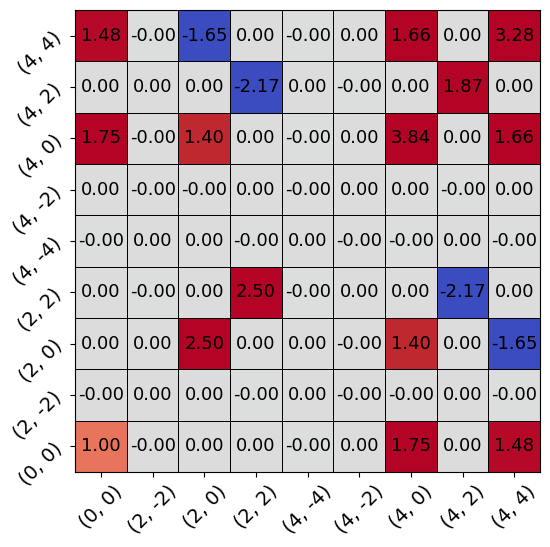

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plot_ip_array(ax, 'SC')

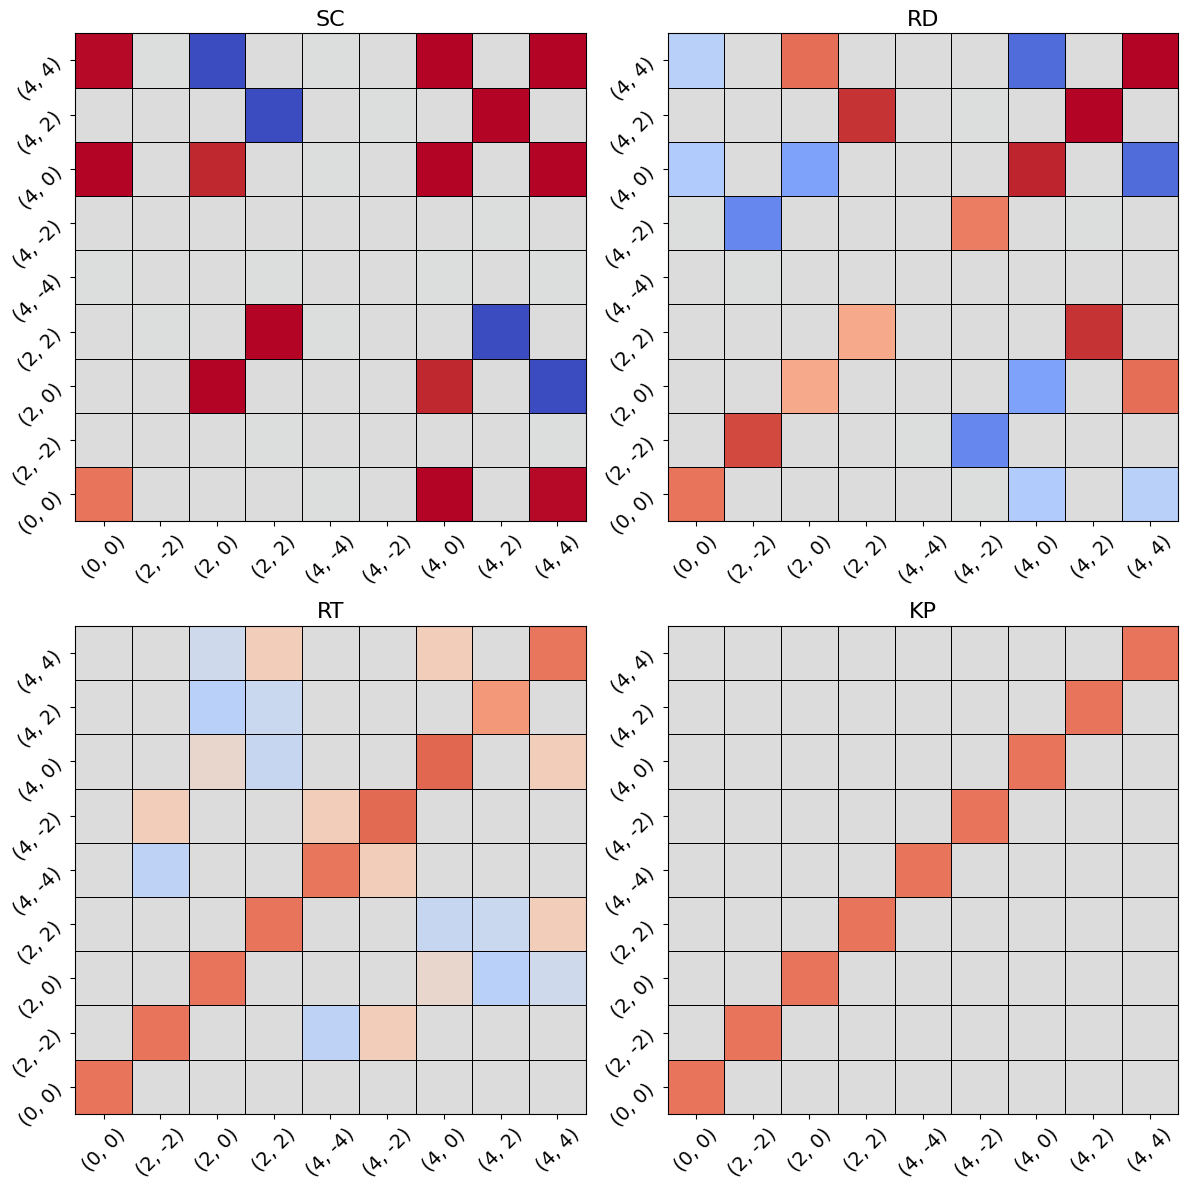

In [7]:
gridlist = ['SC', 'RB', 'RT', 'KP']
gridtitlelist = ['SC', 'RD', 'RT', 'KP']
fig = plt.figure(figsize=(12,12))

for idx, grid in enumerate(gridlist):
    ax = fig.add_subplot(2,2,idx+1)
    plot_ip_array(ax, grid, notext=True)
    ax.set_title(gridtitlelist[idx], fontsize=16)

plt.tight_layout()

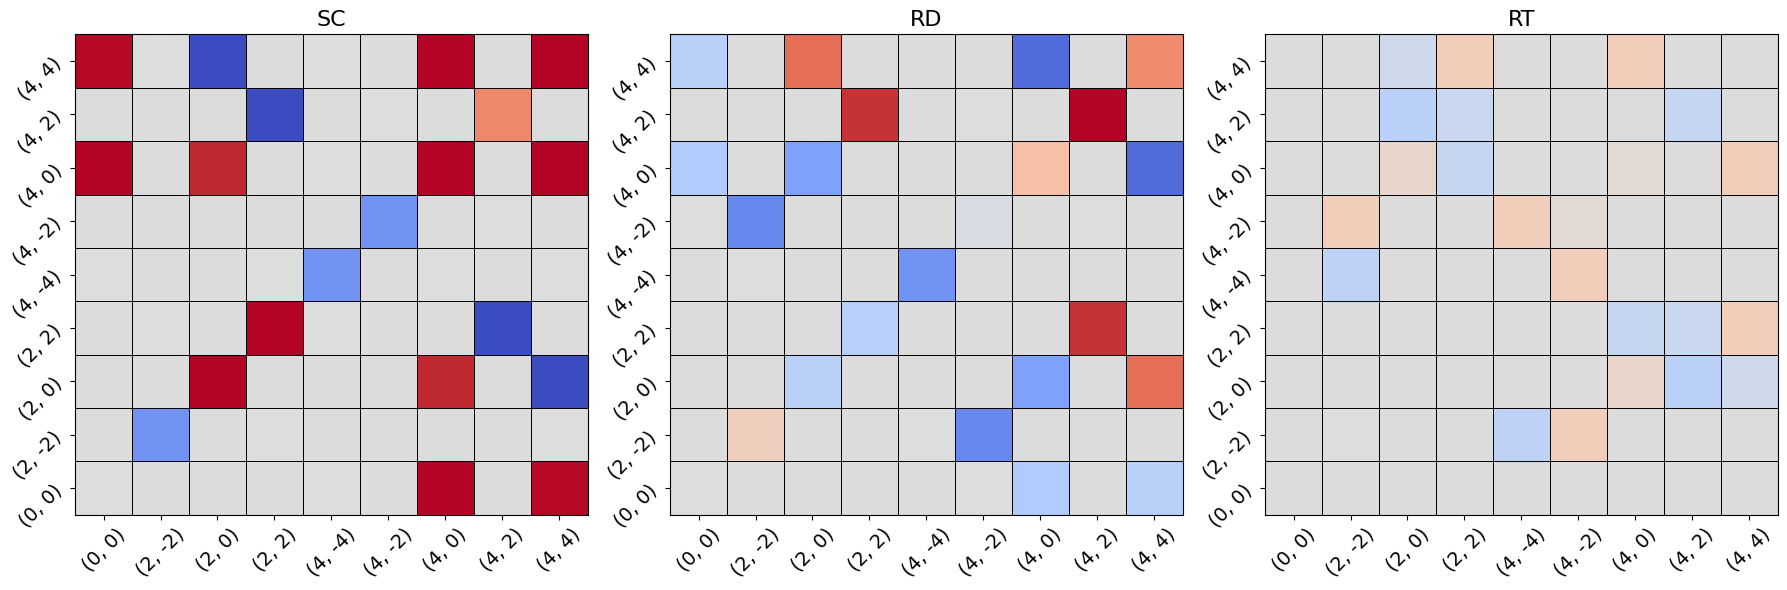

In [8]:
gridlist = ['SC', 'RB', 'RT']
gridtitlelist = ['SC', 'RD', 'RT']
fig = plt.figure(figsize=(18,6))

for idx, grid in enumerate(gridlist):
    ax = fig.add_subplot(1,3,idx+1)
    plot_ip_array(ax, grid, difference=True, vmin=-1.5, vmax=1.5, notext=True)
    ax.set_title(gridtitlelist[idx], fontsize=16)

plt.tight_layout()

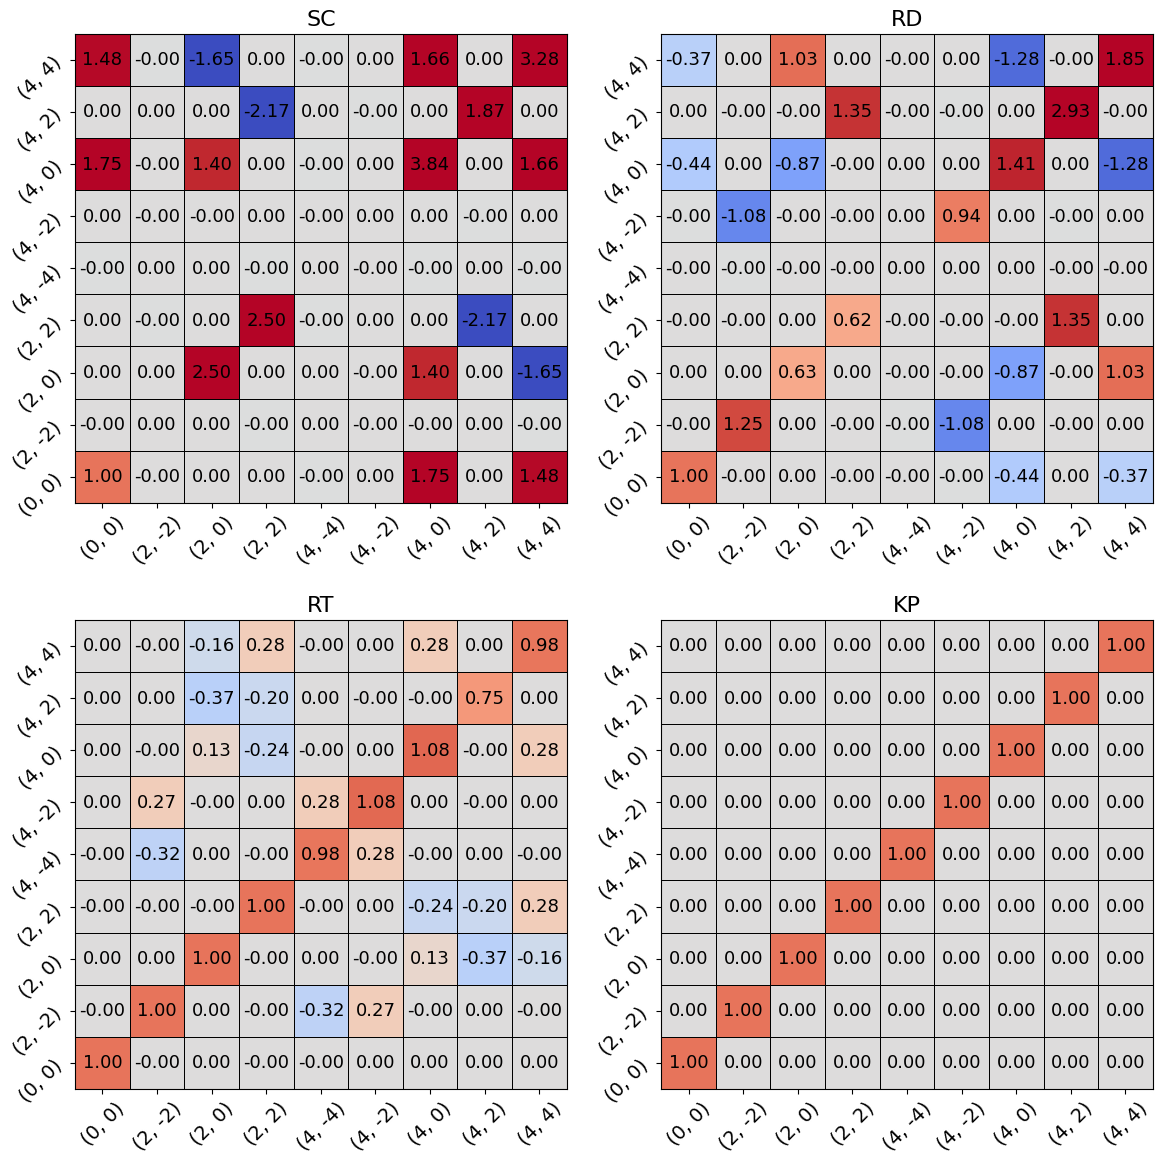

In [9]:
gridlist = ['SC', 'RB', 'RT', 'KP']
gridtitlelist = ['SC', 'RD', 'RT', 'KP']
fig = plt.figure(figsize=(12,12))

for idx, grid in enumerate(gridlist):
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(gridtitlelist[idx], fontsize=16)
    if idx==3:
        plot_ip_array(ax, grid, notext=False)
        continue
    plot_ip_array(ax, grid, difference=False, notext=False)
    ax.set_title(gridtitlelist[idx], fontsize=16)

plt.tight_layout(pad=2.0)